In [95]:
# importing basic libraries
import numpy as np
import pandas as pd
from IPython.display import display

### Importing data

In [96]:
# loading the data
training = pd.read_csv("Training.csv")
test = pd.read_csv("Test.csv")
Y_training = pd.read_csv('Y_Training.csv')

In [97]:
# getting labels
y = Y_training.drop(['id'], axis=1)

print("y shape:",y.shape)

# merging training and Y_training
train = training.merge(Y_training, left_on='id', right_on='id', how='inner')

y shape: (59400, 1)


### Data exploration & understanding

In [98]:
train.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


In [99]:
# getting some key numbers

n_status = train.shape[0]

n_feature = train.shape[1] - 1 #because of the label
 
n_nonfunctional = np.count_nonzero((train['status_group'] == 'non functional'))

n_functional = n_status - n_nonfunctional

functional_rate = n_functional/n_status*100

print('Number of pump status available:', n_status),
print('Number of features in the dataset:', n_feature)
print('Number of functional pumps:', n_functional)
print('Number of non-functional pumps:', n_nonfunctional)
print('Rate of functioning pumps:', round(functional_rate),'%')

Number of pump status available: 59400
Number of features in the dataset: 40
Number of functional pumps: 36576
Number of non-functional pumps: 22824
Rate of functioning pumps: 62 %


In [100]:
# storing and removing id
training_id = training.id
test_id = test.id
training = training.drop("id", inplace = False, axis = 1)
test = test.drop("id", inplace = False, axis = 1)

In [101]:
print("Shape of")
print("- training",training.shape)
print("- test", test.shape)
print("- train", train.shape)

Shape of
- training (59400, 39)
- test (14850, 39)
- train (59400, 41)


### Data Preparation

In [102]:
# dropping the recorded_by column because it only has 1 unique value for both Train and Test
training = training.drop(['recorded_by'], axis=1)
test = test.drop(['recorded_by'], axis=1)

In [103]:
features = pd.concat([training, test]).reset_index(drop=True)
print("features shape:", features.shape)

features shape: (74250, 38)


In [104]:
print("Overview of column types")
print('')
print(features.dtypes)

Overview of column types

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_quality    

### Feature Engineering

#### Dealing with NAs

In [105]:
# chunk of code that Laurens used in the Kaggle House Prices competition
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values.")

                       0       1
scheme_name        35258  object
scheme_management   4846  object
installer           4532  object
funder              4504  object
public_meeting      4155  object
permit              3793  object
subvillage           470  object
There are 7 columns with missing values.


In [106]:
# filling missing values with 'None' for the following features: funder, scheme_name, subvillage 
features.update(features['funder'].fillna('None'))
features.update(features['scheme_name'].fillna('None'))
features.update(features['subvillage'].fillna('None'))

In [107]:
# filling missing values with median for: public_meeting, permit 
features.update(features['public_meeting'].fillna(features['public_meeting'].median()))
features.update(features['permit'].fillna(features['permit'].median()))

In [108]:
# filling missing values with mode for: installer, scheme_management
features.update(features['installer'].fillna(features['installer'].mode()[0]))
features.update(features['scheme_management'].fillna(features['scheme_management'].mode()[0]))

#### Other transformations

In [109]:
# Replaced by MEDIAN

# year 0 in: construction_year
features['construction_year'].replace(to_replace=[0], 
                                      value = features['construction_year'].median(),
                                      inplace=True)



# Replaced by MODE

# unkown value in: payment
features['payment'].replace(to_replace=['unknown'], 
                                      value = features['payment'].mode(),
                                      inplace=True)

# unkown value in: water_quality
features['water_quality'].replace(to_replace=['unknown'], 
                                      value = features['water_quality'].mode(),
                                      inplace=True)

# unkown value in: source_class
features['source_class'].replace(to_replace=['unknown'], 
                                      value = features['source_class'].mode(),
                                      inplace=True)

# to check it worked well: list(set(features['source_class']))

#### Creating some features

In [110]:
print("Data type of date_recorded is:", features['date_recorded'].dtype)
# so we need to convert a datetime to an integer to make some features

Data type of date_recorded is: object


In [111]:
# setting date_recorded as datetime type
features['date_recorded'] = pd.to_datetime(features['date_recorded'], format='%Y-%m-%d')
print("type of 'date_recorded' :", features['date_recorded'].dtype)

# creating a feature: year_recorded
features['year_recorded'] = features['date_recorded'].dt.year

type of 'date_recorded' : datetime64[ns]


In [112]:
# time how many years the pump has been in activity at the recorded date
features['years_activity_when_rec'] = (features['year_recorded'] - features['construction_year'])
features['years_activity_when_rec'] = features['years_activity_when_rec'].astype(int)

In [113]:
# I drop 'subvillage' as it has too many classes and would add mostly noise to the model. It is just a more granular version 
# of 'region'
features = features.drop("subvillage", axis = 1)

In [114]:
# creating a new feature to have the number of years since last time records happened
from datetime import datetime
now = datetime.now()
for i in range(len(features['date_recorded'])):
    features.loc[i,'last_recorded'] = (now - features.loc[i,'date_recorded']).days
features['last_recorded'] = features['last_recorded'].astype(int)

0.0    -7.0
0.1     3.0
0.2     6.0
0.3    11.0
0.4    16.0
0.5    25.0
0.6    25.0
0.7    25.0
0.8    26.0
0.9    31.0
1.0    53.0
Name: years_activity_when_rec, dtype: float64

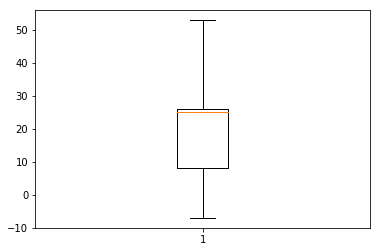

In [115]:
# checking some irregularities
import matplotlib.pyplot as plt
%matplotlib inline  

plt.boxplot(features.years_activity_when_rec)
features.years_activity_when_rec.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [116]:
# we shouldn't have negative values, so let's input 0.
features['years_activity_when_rec'][features['years_activity_when_rec'] < 0] = 0

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000025E6D32DF98>>
Traceback (most recent call last):
  File "C:\Users\lramp\Anaconda3\lib\site-packages\xgboost\core.py", line 366, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
C:\Users\lramp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Rescaling some numerical features

In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features_to_rescale = ['population', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'last_recorded', 
                       'years_activity_when_rec']

for i in features_to_rescale:
    features[i] = scaler.fit_transform(features[i].values.reshape(-1,1))

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### Encoding categorical values

In [118]:
# label encoder should be preferred over One-Hot encoding, as we are going to use Random Forest for modeling
from sklearn.preprocessing import LabelEncoder

features_to_encode = ['date_recorded', 'year_recorded', 'years_activity_when_rec', 'funder', 'installer', 'wpt_name', 
                      'basin', 'region','region_code', 'district_code','lga', 'ward', 'public_meeting', 'scheme_management', 
                      'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_group', 
                      'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 
                      'quality_group', 'quantity', 'quantity_group', 'source','source_type', 'source_class', 'waterpoint_type', 
                      'waterpoint_type_group', 'num_private']


cols = features_to_encode
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(features[c].values)) 
    features[c] = lbl.transform(list(features[c].values))

In [119]:
# we have to split again the data between train and test
X = features.iloc[:len(train),:]
testing_features = features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)
print("Good, both dimensions are coherent.")

(59400, 40)
(14850, 40)
Good, both dimensions are coherent.


#### Dealing with outliers

In [120]:
from sklearn.neighbors import LocalOutlierFactor

In [121]:
detector = LocalOutlierFactor(n_neighbors=20, contamination=0.0001, n_jobs=3)
outliers_predictions = detector.fit_predict(X)

In [122]:
outliers = []
for index, value in enumerate(outliers_predictions):
     if value == -1:
        outliers.append(index)
print('number of outliers to remove:', len(outliers))

number of outliers to remove: 6


In [123]:
print(X.shape)
print(y.shape)

(59400, 40)
(59400, 1)


In [124]:
# removing them
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])
print(X.shape)
print(y.shape)

(59394, 40)
(59394, 1)


### Modeling - Random Forest with StratifiedKFold

In [31]:
# importing libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [32]:
## From Jina's code
# create StratifiedKFold instance
skf = StratifiedKFold(5)

# Use randomizedsearchcv to find the best parameters
rf = RandomForestClassifier(criterion =  'gini', bootstrap = True)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = {'min_samples_split': [5, 10],
                                                 'n_estimators': [1000,1200],
                                                 'max_features': ['auto', 'sqrt'],
                                                 'max_depth': [30, 60, 90]}, 
                               cv = skf, verbose=10, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 40.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'min_samples_split': [5, 10], 'n_estimators': [1000, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [30, 60, 90]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [33]:
# retrieve the best estimator
rf_tuned = rf_random.best_estimator_
rf_tuned

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
# get cross validated score using best estimator
rf_tuned_acc = cross_val_score(rf_tuned, X, y.values.ravel(), cv = skf, scoring = 'accuracy', verbose = 5)

[CV]  ................................................................
[CV] ........................ , score=0.819949494949495, total= 1.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8123737373737374, total= 1.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8152201363751157, total= 1.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.6min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8123421451422799, total= 1.9min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.4min remaining:    0.0s


[CV]  ................................................................
[CV] ........................ , score=0.815694198871769, total= 1.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.3min finished


In [35]:
print("average cross validated accuracy score:",np.mean(rf_tuned_acc))

average cross validated accuracy score: 0.8151159425424794


In [87]:
# exporting the model
from sklearn.externals import joblib
joblib.dump(rf_tuned, "rf_tuned.pkl")

['rf_tuned.pkl']

In [125]:
# importing the model back
from sklearn.externals import joblib
rf_tuned_imported = joblib.load("rf_tuned.pkl")

### Prediction Random Forest

In [36]:
# fit data to model and predict using test data
rf_tuned_imported.fit(X, y.values.ravel()) # or rf_tuned_imported.fit
prediction = rf_tuned.predict(testing_features) # same, _imported

In [37]:
#prediction = rf_tuned.fit(X, y.values.ravel()).predict(testing_features)
submission = pd.DataFrame()
submission['id'] = test_id
submission['status_group'] = prediction

submission.to_csv("Pump_it_up_Random_Forest_submission.csv",index = False)

### Score Random Forest: 

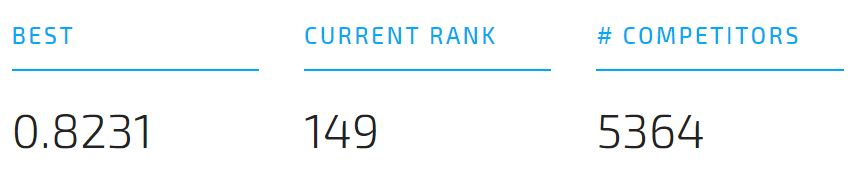

In [38]:
from IPython.display import Image
Image(filename='Score RF.jpg',width="500")

### Modeling - XGBoost with Bayesian Optimization

In [39]:
#Encoding status_group of train to pass it through our models
#y = Y_training.status_group
LEncoder = LabelEncoder()
LEncoder.fit(y)
labels = LEncoder.transform(y)
print(LEncoder.classes_)

display(labels[:10])

['functional' 'functional needs repair' 'non functional']


C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, 2, 0, 0, 2, 2, 2, 0], dtype=int64)

In [40]:
from sklearn.cross_validation import cross_val_score as cv_s
from bayes_opt import BayesianOptimization as BayesOpt
import xgboost as xgb

# in the Cloud, use
#!pip install numpy scipy scikit-learn bayesian-optimization
#from bayes_opt import BayesianOptimization as BayesOpt
# link used to find the library http://philipperemy.github.io/visualization/

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [41]:
# Setting up the bayesian-optimization
# Comment out any parameter you don't want to test

def xgbcv(max_depth,  
          learning_rate, 
          n_estimators,
          min_child_weight,
          gamma,
          subsample,
          colsample_bytree,
          reg_alpha, 
          reg_lambda,
          silent=True):
    return cv_s(xgb.XGBClassifier(max_depth=int(max_depth),
                                 learning_rate=learning_rate,
                                 n_estimators=int(n_estimators),
                                 gamma=gamma,
                                 reg_alpha=reg_alpha,
                                 min_child_weight=min_child_weight,
                                 objective='multi:softmax'),
                    X,
                    labels,
                    "accuracy",
                    cv=4).mean() 

##Setting range of parameters for optimization
xgboostBO = BayesOpt(xgbcv,
                                 {
                                  'max_depth': (7,23),
                                  'learning_rate': (0.01, 0.2),
                                  'n_estimators': (200,600),
                                  'gamma': (0.01, 10),
                                  'min_child_weight': (1,40),
                                  'subsample': (0.2, 1),
                                  'colsample_bytree' :(0.2, 1),
                                  'reg_alpha':(0, 10),
                                  'reg_lambda':(0, 10)
                                  })

##### Chunk of code used to find best parameters in Google Cloud

In [42]:
#print ("Start Optimization of XGBoost Model")

#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore')
#    xgboostBO.maximize(init_points=10,n_iter=110, xi=0.0,  acq="poi")

##### Among best parameters, there was:

 Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_depth |   min_child_weight |   n_estimators |   reg_alpha |   reg_lambda |   subsample | 
   
   16 | 08m40s |    0.80978 |             0.2421 |    1.1838 |          0.1843 |     12.3736 |             1.1236 |       844.5854 |      0.5786 |       3.2621 |      0.3000 | 
   
   26 | 07m22s |    0.80904 |             0.8317 |    0.2797 |          0.0491 |     15.9677 |            18.8218 |       584.5238 |      6.5628 |       2.9337 |      0.8397 | 
   
   21 | 07m33s |    0.80902 |             0.7205 |    0.1300 |          0.0365 |     16.7366 |            22.1178 |       575.6791 |      7.2769 |       6.2152 |      0.8928 | 
    
    
The 3rd (last one) scored the best among these 3 when submitting. So I keep it as my best parameters

In [43]:
# best parameters
best_param = {
    'colsample_bytree': 0.7205,
    'gamma': 0.1300,
    'learning_rate': 0.0365,
    'max_depth' : 17,
    'min_child_weight': 22.1178,
    #'n_estimators': 575,  #mentioned as num_boost_round in xgb.train 
    'reg_alpha': 7.2769,
    'reg_lambda': 6.2152,
    'subsample': 0.8928,
    'objective':'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'seed' : 17 }

In [44]:
train_dmatrix = xgb.DMatrix(X, label=labels, missing=np.nan)
print(X.shape)
print(labels.shape)

(59394, 40)
(59394,)


In [45]:
clf_XGB = xgb.train(best_param, dtrain=train_dmatrix, num_boost_round=575, maximize=False) # 

### Prediction XGBoost

In [46]:
test_dmatrix = xgb.DMatrix(testing_features, missing=np.nan)
prediction2 = clf_XGB.predict(test_dmatrix)

In [47]:
y_pred = LEncoder.inverse_transform(prediction2.astype(int))
df = pd.DataFrame({'id': test_id, 'status_group': y_pred.ravel()})
df.to_csv("Pump_it_up_XGB_submission.csv",index = False)

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


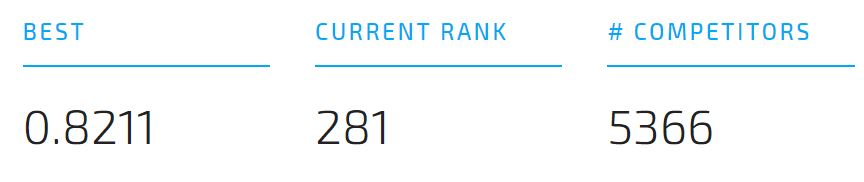

In [48]:
Image(filename='Score XGB.jpg',width="500")

### Modeling - Ensemble method: Stacking RF & XGB (from Laurens notebook)

In [74]:
# pip install mlxtend
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

## Here the previous XGB library on which I had run the hyperparameters can't work for StackingCVClassifier... 
## So i decided to use the XGB Classifier

#clf1 = clf_XGB
clf1 = XGBClassifier(colsample_bytree = 0.7205, 
                     gamma = 0.1300, 
                     learning_rate = 0.0365, 
                     max_depth = 17, 
                     min_child_weight = 22.1178, 
                     n_estimators = 575, 
                     reg_alpha = 7.2769,
                     reg_lambda = 6.2152,
                     subsample = 0.8928,
                     objective = 'multi:softmax', 
                     num_class = 3, 
                     eval_metric = 'mlogloss')
 


clf2 = rf_tuned

stack_gen = StackingCVClassifier(classifiers=[clf1, clf2],
                                meta_classifier=clf2, verbose=2,
                                use_features_in_secondary=True)

#prepare dfs
stackX = np.array(X)
stacky = np.array(labels)

In [75]:
stack_gen_model = stack_gen.fit(stackX, stacky)

Fitting 2 classifiers...
Fitting classifier1: xgbclassifier (1/2)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7205, eval_metric='mlogloss', gamma=0.13,
       learning_rate=0.0365, max_delta_step=0, max_depth=17,
       min_child_weight=22.1178, missing=None, n_estimators=575, n_jobs=1,
       nthread=None, num_class=3, objective='multi:softmax',
       random_state=0, reg_alpha=7.2769, reg_lambda=6.2152,
       scale_pos_weight=1, seed=None, silent=True, subsample=0.8928)
Training and fitting fold 1 of 2...


C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training and fitting fold 2 of 2...


C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting classifier2: randomforestclassifier (2/2)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training and fitting fold 1 of 2...
Training and fitting fold 2 of 2...


In [76]:
# exporting the model
from sklearn.externals import joblib
joblib.dump(stack_gen_model, "stack_model_rf&xgb.pkl")

['stack_model_rf&xgb.pkl']

In [77]:
# importing the model back
from sklearn.externals import joblib
stack_model_imported = joblib.load("stack_model_rf&xgb.pkl")

In [78]:
xgb_opt2 = stack_model_imported.clfs_[0]
rf_stack = stack_model_imported.clfs_[1]

In [79]:
from sklearn.externals import joblib
joblib.dump(xgb_opt2, "xgb_opt2.pkl")

['xgb_opt2.pkl']

In [80]:
stack_gen_model

StackingCVClassifier(classifiers=[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7205, eval_metric='mlogloss', gamma=0.13,
       learning_rate=0.0365, max_delta_step=0, max_depth=17,
       min_child_weight=22.1178, missing=None, n_estimators=575, n_jobs=1,
       nthread... n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)],
           cv=2,
           meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           shuffle=True, store_train_meta_features=False, stratify=True,
           use_clones=True, use_fea

In [138]:
stack_gen_preds = stack_gen_model.predict(np.array(testing_features))

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [139]:
stack_gen_preds = pd.DataFrame(stack_gen_preds)
stack_gen_preds.head(3)

,0
0,2
1,0
2,0


In [142]:
stack_gen_preds[0] = stack_gen_preds[0].replace({0:"functional",
                                                 1:"functional needs repair",
                                                 2:"non functional"})
stack_gen_preds.head()

,0
0,non functional
1,functional
2,functional
3,non functional
4,functional


In [144]:
submission = pd.DataFrame()
submission['id'] = test_id
submission['status_group'] = stack_gen_preds

submission.to_csv("Pump_it_up_Stacked_submission.csv",index = False)

The score is good, but not as good as Random Forest.

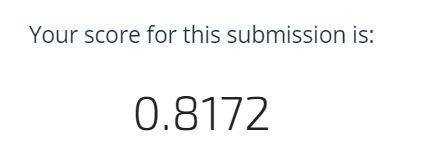

In [146]:
Image(filename='Score stacked.jpg',width="300")

##### As a reminder, we have:
##### - RF: 0.8231
##### - XGB: 0.8211
##### - Stacked: 0.8172

Let's add a voting classifier to see if we can still improve our score

### Voting classifier

In [153]:
from sklearn.ensemble import VotingClassifier

clf3 = stack_gen

print('XGB:')
print(clf1)
print('RF:')
print(clf2)
print('Stacked:')
print(stack_gen)

eclf = VotingClassifier(estimators = [('stackgen', clf3),
                                      ('rf', clf2), ('xgb', clf1)],
                       voting = 'soft', weights = [3,4,2])

eclf_fit = eclf.fit(np.array(X), np.array(y))

XGB:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7205, eval_metric='mlogloss', gamma=0.13,
       learning_rate=0.0365, max_delta_step=0, max_depth=17,
       min_child_weight=22.1178, missing=None, n_estimators=575, n_jobs=1,
       nthread=None, num_class=3, objective='multi:softmax',
       random_state=0, reg_alpha=7.2769, reg_lambda=6.2152,
       scale_pos_weight=1, seed=None, silent=True, subsample=0.8928)
RF:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Stacked:
StackingCVClassifier(classifiers=[XGBClassifier(base_score=0.5, booster='gbtree', colsample_byleve

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting classifier1: xgbclassifier (1/2)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7205, eval_metric='mlogloss', gamma=0.13,
       learning_rate=0.0365, max_delta_step=0, max_depth=17,
       min_child_weight=22.1178, missing=None, n_estimators=575, n_jobs=1,
       nthread=None, num_class=3, objective='multi:softmax',
       random_state=0, reg_alpha=7.2769, reg_lambda=6.2152,
       scale_pos_weight=1, seed=None, silent=True, subsample=0.8928)
Training and fitting fold 1 of 2...


C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training and fitting fold 2 of 2...


C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting classifier2: randomforestclassifier (2/2)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Training and fitting fold 1 of 2...
Training and fitting fold 2 of 2...


In [154]:
from sklearn.externals import joblib
joblib.dump(eclf_fit, "voting_clf.pkl")

['voting_clf.pkl']

In [155]:
voting_clf  = joblib.load("voting_clf.pkl")

In [156]:
voting_clf.score(np.array(X), np.array(y))

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9265582382058793

In [157]:
voting_preds = voting_clf.predict(np.array(testing_features))

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [160]:
voting_preds = pd.DataFrame(voting_preds)
voting_preds.head()

,0
0,non functional
1,functional
2,functional
3,non functional
4,functional


In [161]:
submission = pd.DataFrame()
submission['id'] = test_id
submission['status_group'] = voting_preds

submission.to_csv("Pump_it_up_Voting_submission.csv",index = False)

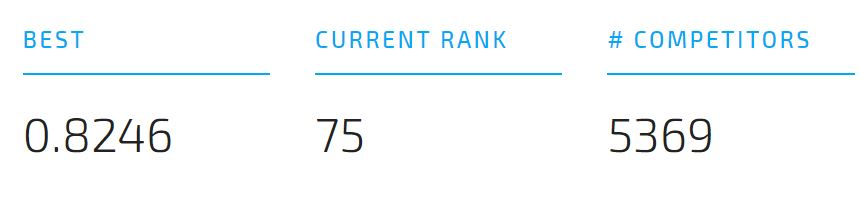

In [163]:
Image(filename='Score Voting_clf.jpg',width="500")

## Final score: 0.8246
## Top 1.39% of competitors

#### ROC analysis - Random Forest (needed for an interview)

In [67]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

In [68]:
# multi-class classification
y = label_binarize(y, classes=['functional','non functional','functional needs repair'])

n_classes = 3

In [69]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.25, random_state=8)

In [70]:
# Random Forest classifier
clf = OneVsRestClassifier(RandomForestClassifier())
y_score = clf.fit(X_train, y_train).predict(X_test)

In [71]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

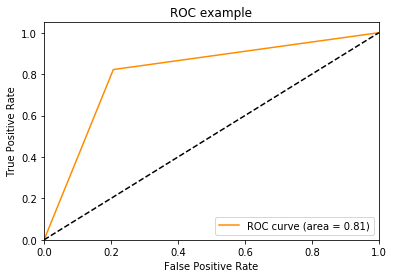

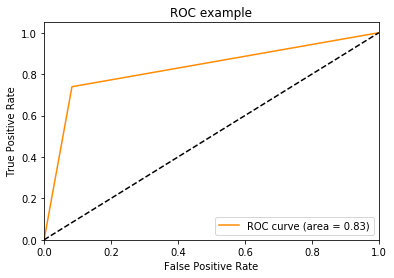

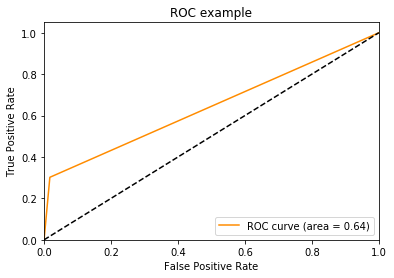

In [72]:
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC example')
    plt.legend(loc="lower right")
    plt.show()

J'ai utilisé 75% du dataset pour le training, et donc 25% pour le test.
Il y en a 3, puisqu'il y en a 1 par label.

##### Pour les prédictions "functional"
Bon ROC, suffisamment distant de la droite de référence c'est à dire de la random measure en pointillé.
L'AUC (Area Under the Curve) est de 0.81 ce qui est convenable. 
Le ratio True Positive sur False Positive en "début de courbe" est satisfaisant (pour de la maintenance de pompes à eau...). Le modèle identifie donc bien un peu plus de 80% des pompes en état de marche, avec un bon ratio de 0.83/0.2 .

##### Pour les prédictions "non functional" 
Le ROC est également bon pour ce label, avec une AUC supérieure à 0.83.
Le True Positive Rate a un très bon ratio par rapport au False Positive Rate en "début de courbe". Cela signifie que le modèle identifie vraiment bien la majorité des True Positive. Ce ratio est vraiment bon.

##### Pour les prédictions "functional needs repair"
Mauvais ROC , faible distinction par rapport à la droite de référence.
Cela se ressent évidemment sur la AUC qui est à 0.64. Il est donc difficile de pronostiquer efficacement les pompes qui ont besoins de réparation.
Seulement 30% des True Positives sont prédits avec une quasi-certitude. C'est très faible ! Au-delà le modèle converge vers la random measure.
